<a href="https://colab.research.google.com/github/ISABEL021/EXERCICIO_CURSO/blob/main/C%C3%B3pia_de_Images_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ELE 2346 - DEEP LEARNING**
# Hands-On: Semantic Segmentation

**Application:**
Aerial Semantic Segmentation Drone Dataset

**Dataset Resource**
https://www.tugraz.at/index.php?id=22387

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/img_dl_3.png'/>
</figure>


In [1]:
# Import libraries
import os
import cv2
import time
import torch
import numpy as np 
import torchvision
import torch.nn as nn
from PIL import Image
import albumentations as A
from google.colab import drive
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

!pip install -q segmentation-models-pytorch
# https://smp.readthedocs.io/en/latest/models.html
!pip install -q torchsummary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.0 MB/s eta 0:00:00
cpu


# **Getting training dataset**

In [ ]:
!git clone https://gitlab.uni-hannover.de/ortega/dataset_drone.git

In [ ]:
!unzip dataset_drone/data.zip

In [ ]:
# mount your Google Drive
drive.mount('/content/drive', force_remount=True)
root_path = '/content/drive/My Drive/Colab Notebooks/DL_Courses/DL_2023a_Semantic_Segmentation/' 
os.chdir(root_path)
from utils import *

In [ ]:
from utils import *

# **Splitting the data into training and test**

In [ ]:
n_classes = 23 
df = create_df('data/images/')
print('Total Images: ', len(df))
# Split data (training-validation-test)
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Total Images:  79
Train Size   :  60
Val Size     :  11
Test Size    :  8


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


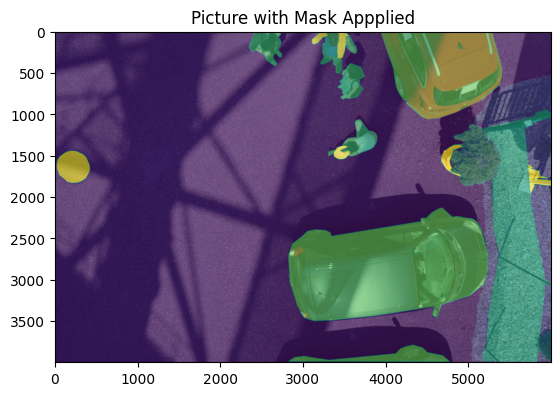

In [ ]:
# sample visualization
num_sample = 10
vis_sample(df, 'data/images/', 'data/labels/', num_sample)

In [ ]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        #self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        # data-augmentation
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(176, 264, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.GaussNoise()])

t_val = A.Compose([A.Resize(176, 264, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset('data/images/', 'data/labels/', X_train, mean, std, t_train)
val_set = DroneDataset('data/images/', 'data/labels/', X_val, mean, std, t_val)

#dataloader
batch_size= 4 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)  

# **Defining DL model (U-Net)**

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=3, decoder_channels=[256, 128, 64])

In [ ]:
def fit(epochs, root_path, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            output = output#.long()
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    output = output#.long()
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculation mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            # Early stop
            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease = 5
                print('saving model...')
                #torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                torch.save(model, root_path + 'Unet-Mobilenet.pt')
            else:
               decrease -= 1
            if decrease < 0:
                print('[***] end training ...')      
                break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
lr_ = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr_, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, '.', model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([4, 3, 176, 264]) torch.Size([4, 176, 264])
torch.Size([4, 3, 176, 264]) torch.Size([4, 176, 264])


KeyboardInterrupt: ignored

# **Plotting loss funcion**

In [ ]:
#torch.save(model, root_path + 'Unet-Mobilenet.pt')
plot_loss(history)
plot_score(history)
plot_acc(history)

# **Test set**

In [ ]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask
        
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset('contentdata/images/', 'contentdata/labels/', X_test, transform=t_test)

# **Inference**

In [ ]:
model = torch.load(root_path + 'Unet-Mobilenet.pt') 

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask, device)

mob_miou = miou_score(model, test_set, device)

mob_acc = pixel_acc(model, test_set, device)
vis_prediction(image, mask, pred_mask, score)

In [ ]:
vis_prediction(image, mask, pred_mask, score)

In [ ]:
image2, mask2 = test_set[5]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2, device)

vis_prediction(image2, mask2, pred_mask2, score2)

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

# **Excercise**

Fill the next table varying the parameters


Name        || Learning rate || encoder_depth || Filters || Prec. || Rec. || F1 ||
 --- || --- || --- || --- || --- || --- || --- ||
name 1      ||  **'1e-3'**   ||  **7**     || **[256,128,64,32,16,8,4]**    || - || - || - ||
name 2      ||  **'1e-3'**   ||  **6**    || **[256,128,64,32,16,8]**       || - || - || - ||
name 3      ||  **'1e-3'**   ||  **5**    || **[256,128,64,32,16]**         || - || - || - ||
name 4      ||  **'1e-3'**   ||  **4**    || **[256,128,64,32]**            || - || - || - ||
name 5      ||  **'1e-3'**   ||  **3**     || **[256,128,64]**              || - || - || - ||


# **Homework 2 - Semantic Segmentation**

Objective: Implement a DeepLabV3+ Network for semantic segmentation using Segmentation Models of pytorch.

Dataset:

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/drawing1.png'/>
</figure>


Steps:
1. Split the image "Train" for training (80%) and validation (20%).
2. Generate patches from the training image (128x128, 64x64, 32x32)
3. Train a DeepLabV3+ network using the Segmentation Models of pytorch using the ecoder of 'mobilenet_v2' from scratch and with pretrained weights of 'imagenet', encoder_depth=4, decoder_channels=[256, 128, 64, 32]
4. For training, use the “weighted_categorical_crossentropy” as a loss function. To compute the weights you must count the number of pixels of each class.
5. Evaluate the model on the image "Test" using patches and make the mosaic to visualize the complete image.
6. Compute metrics for each class.
7. Compare and analize the results.


** pre-precessing on ImageNet: ** 

normalization: (mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])

** from scratch [0-1] **

You should send the compiled notebook

### 1. Split the Image for training and validation

In [ ]:
class NeighborDataset(Dataset):
    
    def __init__(self, img_path, mask_path, mean, std, train_limit, val = False, transform=None, scale01 = False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform
        self.mean = mean
        self.std = std
        self.train_limit = train_limit
        self.val = val
        self.scale01 = scale01
        
    def __len__(self):
        return 50
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path, cv2.IMREAD_GRAYSCALE)

        #the split happens here
        if self.val:
          img = img[self.train_limit:,:,:]
          mask = mask[self.train_limit:,:]
        else:
          img = img[:self.train_limit,:,:]
          mask = mask[:self.train_limit,:]

        # data-augmentation
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)

        if self.scale01:        
          t = T.Compose([T.ToTensor()])
        else:
          t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = (torch.from_numpy(mask)/255).long()
            
        return img, mask

### 2.1 Generate patches

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
train_limit = int(2565*0.8)
n_classes = 5

#patches are generated by the RandomCrop methods
t_train = A.Compose([A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.GaussNoise(), A.RandomCrop(width=256, height=256)])

t_val = A.Compose([A.HorizontalFlip(),
                   A.GridDistortion(p=0.2), A.RandomCrop(width=256, height=256)])

#datasets
train_set = NeighborDataset(
    '/content/Image_Train.tif',
    '/content/Reference_Train.tif',
    mean, std, train_limit,False,t_train
)
val_set = NeighborDataset(
    '/content/Image_Train.tif',
    '/content/Reference_Train.tif',
    mean, std, train_limit,True, t_val)

#dataloader
batch_size= 5

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)  

### 2.2 Generate patches

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
train_limit = int(2565*0.8)
n_classes = 5

#patches are generated by the RandomCrop methods
t_train = A.Compose([A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.GaussNoise(), A.RandomCrop(width=256, height=256)])

t_val = A.Compose([A.HorizontalFlip(),
                   A.GridDistortion(p=0.2), A.RandomCrop(width=256, height=256)])

#datasets
train_set = NeighborDataset(
    '/content/Image_Train.tif',
    '/content/Reference_Train.tif',
    mean, std, train_limit,False,t_train,scale01=True #scale between 0 - 1
)
val_set = NeighborDataset(
    '/content/Image_Train.tif',
    '/content/Reference_Train.tif',
    mean, std, train_limit,True, t_val, scale01=True) #scale between 0 - 1

#dataloader
batch_size = 5

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)  

### 3.1 Train DeepLabV3 with encoder weights from imagenet

In [ ]:
model = smp.DeepLabV3('mobilenet_v2', encoder_weights='imagenet', classes=5, activation=None, encoder_depth=4, decoder_channels=64)

### 3.2 Train DeepLabV3 from scratch

In [ ]:
model = smp.DeepLabV3('mobilenet_v2', encoder_weights=None, classes=5, activation=None, encoder_depth=4, decoder_channels=64)

### 4.1 Weighted categorical crossentropy

In [ ]:
lr_ = 1e-3
epoch = 12
weight_decay = 1e-4

pixels = []
mask = cv2.imread('/content/Reference_Train.tif')
for class_ in  np.unique(mask[:,:,0] + 2*mask[:,:,1] + 3*mask[:,:,2]):
  pixels.append((mask[:,:,0] + 2*mask[:,:,1] + 3*mask[:,:,2] == class_).sum())
pixels = np.array(pixels)
weights = torch.from_numpy(pixels/np.max(pixels)).float()

#set up weights
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr_, epochs=epoch,
                                            steps_per_epoch=10)

history = fit(epoch, '.', model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.499 
saving model...
Epoch:1/12.. Train Loss: 1.535.. Val Loss: 1.499.. Train mIoU:0.239.. Val mIoU: 0.285.. Train Acc:0.364.. Val Acc:0.569.. Time: 0.92m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. 1.499 >> 1.357 
saving model...
Epoch:2/12.. Train Loss: 1.373.. Val Loss: 1.357.. Train mIoU:0.424.. Val mIoU: 0.604.. Train Acc:0.585.. Val Acc:0.754.. Time: 0.78m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:3/12.. Train Loss: 1.038.. Val Loss: 2.403.. Train mIoU:0.606.. Val mIoU: 0.560.. Train Acc:0.802.. Val Acc:0.733.. Time: 0.77m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. 1.357 >> 1.284 
saving model...
Epoch:4/12.. Train Loss: 0.747.. Val Loss: 1.284.. Train mIoU:0.712.. Val mIoU: 0.714.. Train Acc:0.893.. Val Acc:0.838.. Time: 0.84m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:5/12.. Train Loss: 0.580.. Val Loss: 1.507.. Train mIoU:0.744.. Val mIoU: 0.647.. Train Acc:0.921.. Val Acc:0.799.. Time: 0.89m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. 1.284 >> 0.463 
saving model...
Epoch:6/12.. Train Loss: 0.409.. Val Loss: 0.463.. Train mIoU:0.725.. Val mIoU: 0.691.. Train Acc:0.898.. Val Acc:0.873.. Time: 0.84m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:7/12.. Train Loss: 0.382.. Val Loss: 0.498.. Train mIoU:0.694.. Val mIoU: 0.653.. Train Acc:0.921.. Val Acc:0.831.. Time: 0.79m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:8/12.. Train Loss: 0.293.. Val Loss: 0.559.. Train mIoU:0.660.. Val mIoU: 0.671.. Train Acc:0.899.. Val Acc:0.812.. Time: 0.82m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. 0.463 >> 0.332 
saving model...
Epoch:9/12.. Train Loss: 0.256.. Val Loss: 0.332.. Train mIoU:0.626.. Val mIoU: 0.607.. Train Acc:0.879.. Val Acc:0.792.. Time: 0.84m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.280 
saving model...
Epoch:10/12.. Train Loss: 0.232.. Val Loss: 0.280.. Train mIoU:0.721.. Val mIoU: 0.606.. Train Acc:0.925.. Val Acc:0.823.. Time: 0.80m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. 0.280 >> 0.231 
saving model...
Epoch:11/12.. Train Loss: 0.205.. Val Loss: 0.231.. Train mIoU:0.665.. Val mIoU: 0.539.. Train Acc:0.882.. Val Acc:0.752.. Time: 0.76m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:12/12.. Train Loss: 0.208.. Val Loss: 0.241.. Train mIoU:0.621.. Val mIoU: 0.544.. Train Acc:0.848.. Val Acc:0.778.. Time: 0.76m
Total time: 9.81 m


### 4.2 Weighted categorical crossentropy

In [ ]:
lr_ = 1e-3
epoch = 12
weight_decay = 1e-4

pixels = []
mask = cv2.imread('/content/Reference_Train.tif')
for class_ in  np.unique(mask[:,:,0] + 2*mask[:,:,1] + 3*mask[:,:,2]):
  pixels.append((mask[:,:,0] + 2*mask[:,:,1] + 3*mask[:,:,2] == class_).sum())
pixels = np.array(pixels)
weights = torch.from_numpy(pixels/np.max(pixels)).float()

#set up weights
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr_, epochs=epoch,
                                            steps_per_epoch=10)

history = fit(epoch, '.', model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.586 
saving model...
Epoch:1/12.. Train Loss: 1.475.. Val Loss: 1.586.. Train mIoU:0.214.. Val mIoU: 0.008.. Train Acc:0.349.. Val Acc:0.011.. Time: 0.78m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:2/12.. Train Loss: 1.332.. Val Loss: 1.969.. Train mIoU:0.306.. Val mIoU: 0.035.. Train Acc:0.479.. Val Acc:0.027.. Time: 0.85m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:3/12.. Train Loss: 1.098.. Val Loss: 3.862.. Train mIoU:0.361.. Val mIoU: 0.000.. Train Acc:0.622.. Val Acc:0.000.. Time: 0.84m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:4/12.. Train Loss: 0.719.. Val Loss: 3.130.. Train mIoU:0.426.. Val mIoU: 0.000.. Train Acc:0.743.. Val Acc:0.000.. Time: 0.81m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. 1.586 >> 1.238 
saving model...
Epoch:5/12.. Train Loss: 0.595.. Val Loss: 1.238.. Train mIoU:0.436.. Val mIoU: 0.281.. Train Acc:0.813.. Val Acc:0.545.. Time: 0.78m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Decreasing.. 1.238 >> 0.366 
saving model...
Epoch:6/12.. Train Loss: 0.406.. Val Loss: 0.366.. Train mIoU:0.424.. Val mIoU: 0.304.. Train Acc:0.773.. Val Acc:0.598.. Time: 0.82m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:7/12.. Train Loss: 0.303.. Val Loss: 0.377.. Train mIoU:0.425.. Val mIoU: 0.382.. Train Acc:0.764.. Val Acc:0.621.. Time: 0.82m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:8/12.. Train Loss: 0.292.. Val Loss: 0.438.. Train mIoU:0.443.. Val mIoU: 0.391.. Train Acc:0.812.. Val Acc:0.616.. Time: 0.80m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:9/12.. Train Loss: 0.236.. Val Loss: 0.454.. Train mIoU:0.432.. Val mIoU: 0.383.. Train Acc:0.795.. Val Acc:0.615.. Time: 0.83m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:10/12.. Train Loss: 0.224.. Val Loss: 0.507.. Train mIoU:0.430.. Val mIoU: 0.367.. Train Acc:0.796.. Val Acc:0.579.. Time: 0.76m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:11/12.. Train Loss: 0.209.. Val Loss: 0.421.. Train mIoU:0.442.. Val mIoU: 0.370.. Train Acc:0.814.. Val Acc:0.581.. Time: 0.80m


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[***] end training ...
Total time: 9.62 m


### 5.1 Evaluate

In [ ]:
class NeighborTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform
      
    def __len__(self):
        return 10
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = (torch.from_numpy(mask)/255).long()
        
        return img, mask
        
t_test = A.Resize(2048, 2048, interpolation=cv2.INTER_NEAREST)
test_set = NeighborTestDataset('/content/Image_Test.tif',
    '/content/Reference_Test.tif', transform=t_test)

In [ ]:
model = torch.load('/content/.Unet-Mobilenet.pt') 

In [ ]:
def predict_image_mask_miou(model, image, mask, device, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

torch.Size([3, 2048, 2048])
torch.Size([3, 256, 256])
torch.Size([256, 256])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([3, 2048, 2048])
torch.Size([3, 256, 256])
torch.Size([256, 256])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([3, 2048, 2048])
torch.Size([3, 256, 256])
torch.Size([256, 256])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([3, 2048, 2048])
torch.Size([3, 256, 256])
torch.Size([256, 256])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

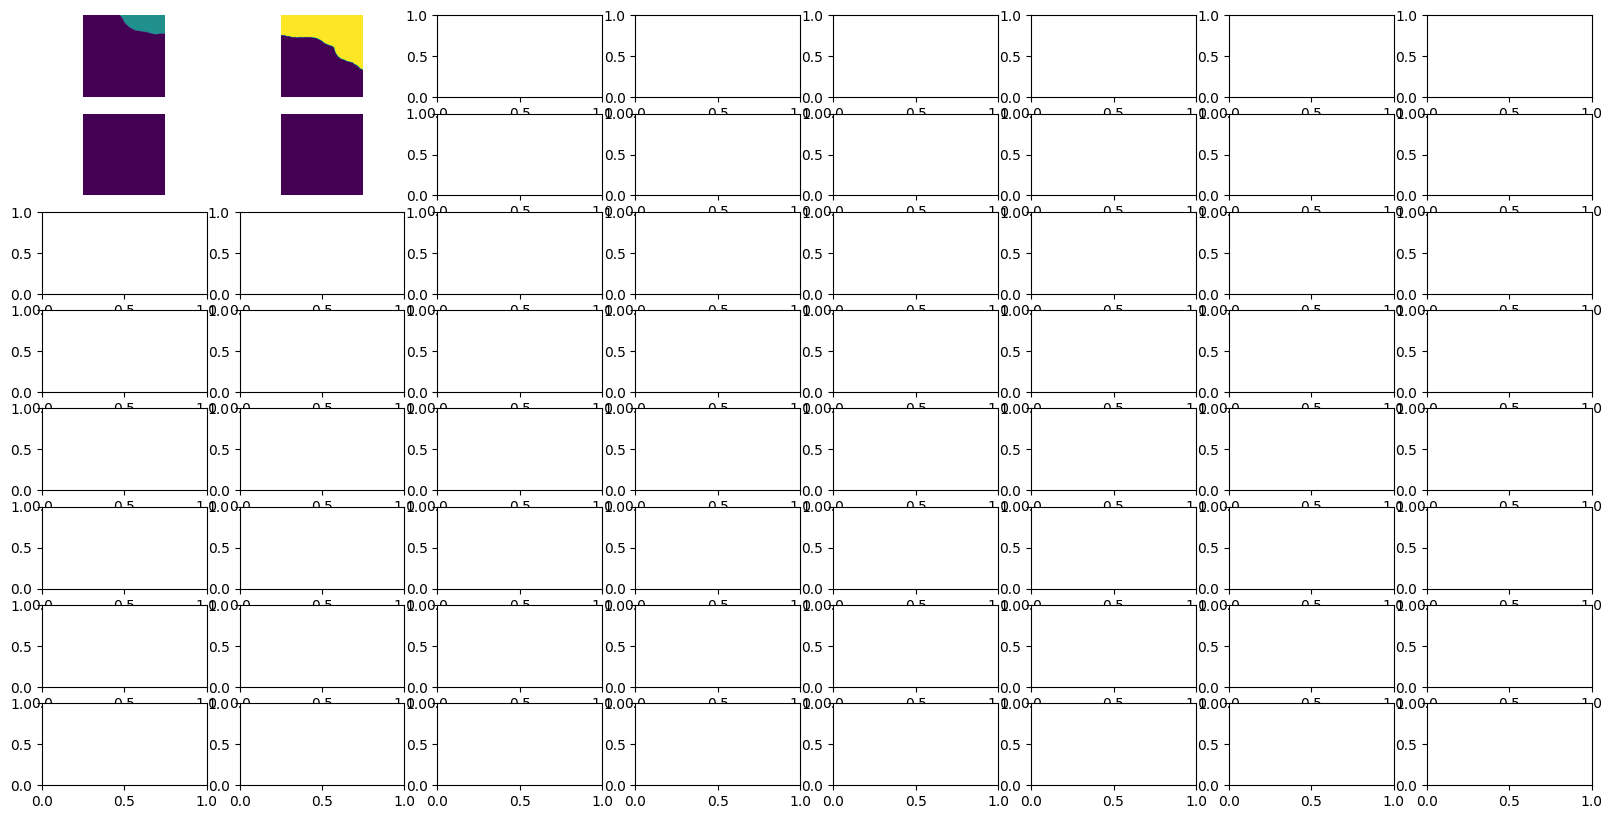

In [ ]:
image = test_set[0][0]
mask = test_set[0][1]
mob_accs = []
mob_mious = []
scores = []
masks = []
preds = []
fig, axs = plt.subplots(8,8, figsize=(20,10))
for i in range(2):
  for j in range(2):
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image_ = t(image)
    print(image_.shape)
    image_ = image_[:,i*256:(i+1)*256,j*256:(j+1)*256]
    mask_ = test_set[0][1][i*256:(i+1)*256,j*256:(j+1)*256]
    print(image_.shape)
    print(mask_.shape)
    masks.append(mask_)
    pred_mask, score = predict_image_mask_miou(model, image_, mask_, device)
    scores.append(score)

    preds.append(pred_mask)
    mob_miou = miou_score(model, test_set, device)
    mob_mious.append(mob_miou)

    mob_acc = pixel_acc(model, test_set, device)
    mob_accs.append(mob_acc)
    axs[i][j].imshow(pred_mask*255)
    axs[i][j].set_axis_off()
    #vis_prediction(image, mask, pred_mask, score)

In [ ]:
mask = test_set[0][1]
plt.imshow(mask)

In [ ]:
fig, axs = plt.subplots(8,8, figsize=(20,10))
for i in range(8):
  for j in range(8):
    mask_ = test_set[0][1][i*252:(i+1)*256,j*256:(j+1)*256]

    axs[i][j].imshow(mask_)
    axs[i][j].set_axis_off()
    #vis_prediction(image, mask, pred_mask, score)

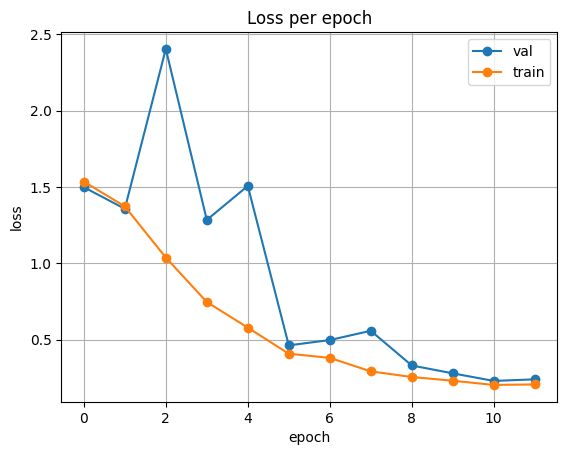

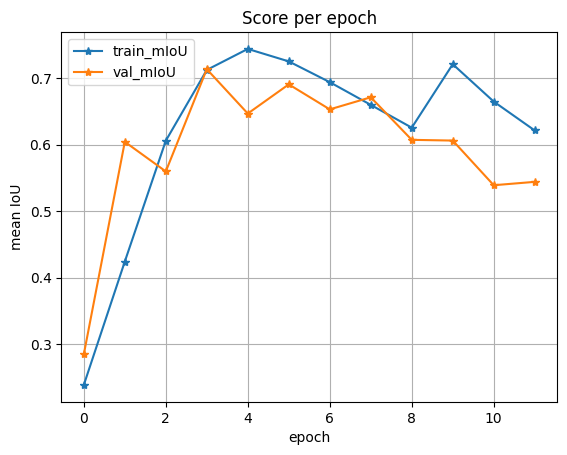

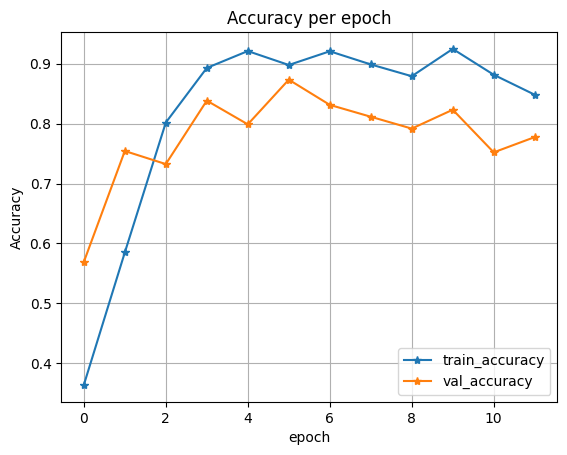

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [ ]:
print(mob_accs)
print(mob_mious)
print(scores)

[[0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578], [0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578], [0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578], [0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578, 0.9204425811767578]]
[[0.7209380690898185, 0.7209380690898185, 0.7209380690898185, 0.7209380690898185, 0.7209380690898185, 0.7209380690898185, 0.7209380690898185, 0.7209380690898185, 0.7209380690898185, 0.7209380

### 5.2 Evaluate

In [ ]:
class NeighborTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform
      
    def __len__(self):
        return 10
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = (torch.from_numpy(mask)/255).long()
        
        return img, mask
        
t_test = A.Resize(2048, 2048, interpolation=cv2.INTER_NEAREST)
test_set = NeighborTestDataset('/content/Image_Test.tif',
    '/content/Reference_Test.tif', transform=t_test)

In [ ]:
model = torch.load('/content/.Unet-Mobilenet.pt') 

In [ ]:
def predict_image_mask_miou(model, image, mask, device, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

torch.Size([3, 2048, 2048])
torch.Size([3, 256, 256])
torch.Size([256, 256])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([3, 2048, 2048])
torch.Size([3, 256, 256])
torch.Size([256, 256])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([3, 2048, 2048])
torch.Size([3, 256, 256])
torch.Size([256, 256])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([3, 2048, 2048])
torch.Size([3, 256, 256])
torch.Size([256, 256])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

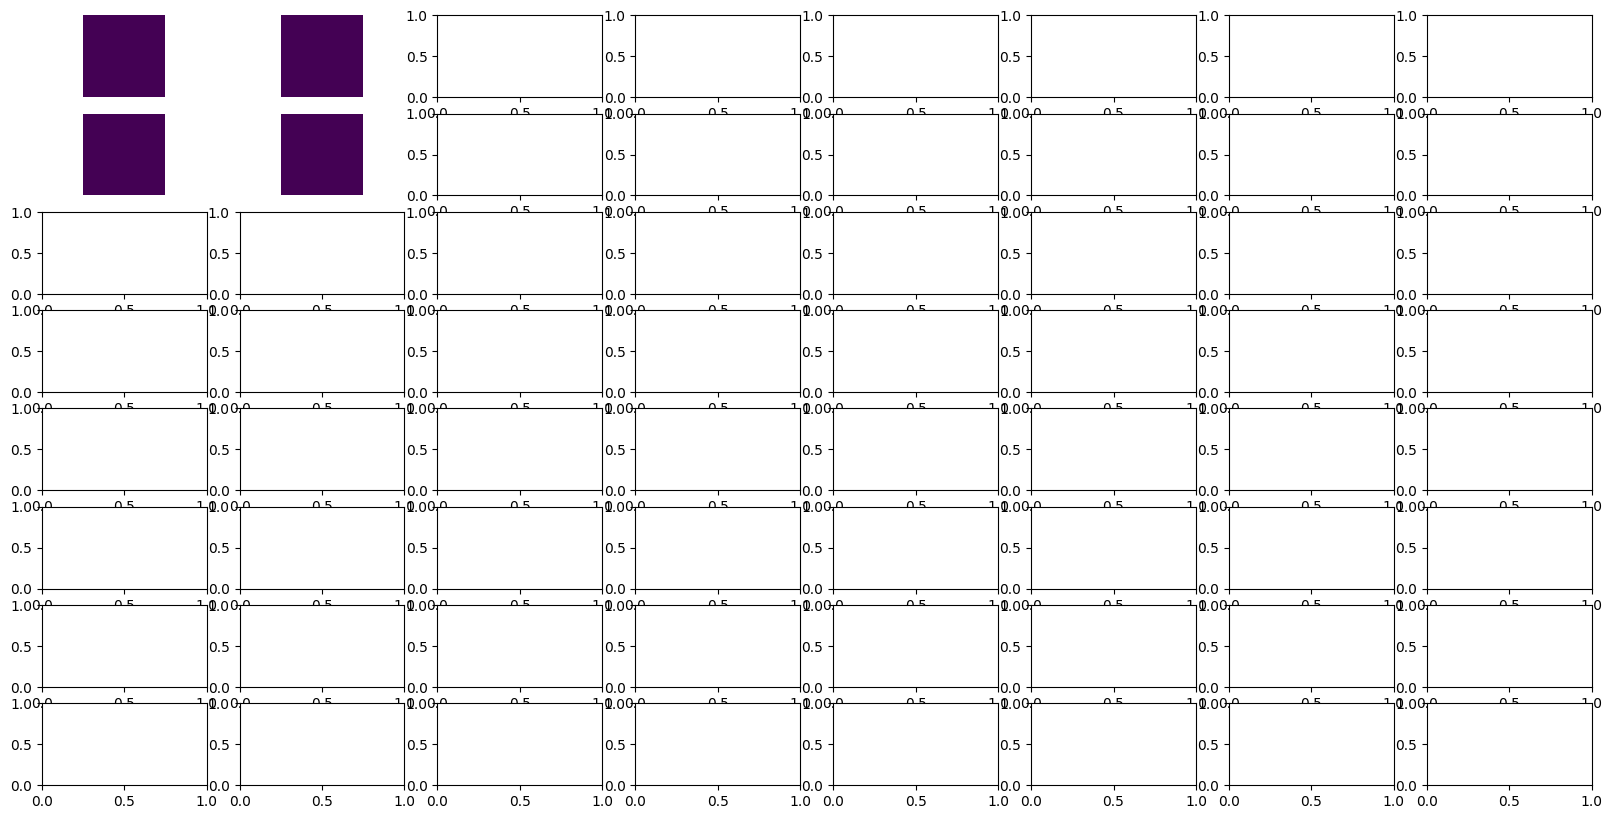

In [ ]:
image = test_set[0][0]
mask = test_set[0][1]
mob_accs = []
mob_mious = []
scores = []
masks = []
preds = []
fig, axs = plt.subplots(8,8, figsize=(20,10))
for i in range(2):
  for j in range(2):
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image_ = t(image)
    print(image_.shape)
    image_ = image_[:,i*256:(i+1)*256,j*256:(j+1)*256]
    mask_ = test_set[0][1][i*256:(i+1)*256,j*256:(j+1)*256]
    print(image_.shape)
    print(mask_.shape)
    masks.append(mask_)
    pred_mask, score = predict_image_mask_miou(model, image_, mask_, device)
    scores.append(score)

    preds.append(pred_mask)
    mob_miou = miou_score(model, test_set, device)
    mob_mious.append(mob_miou)

    mob_acc = pixel_acc(model, test_set, device)
    mob_accs.append(mob_acc)
    axs[i][j].imshow(pred_mask*255)
    axs[i][j].set_axis_off()
    #vis_prediction(image, mask, pred_mask, score)

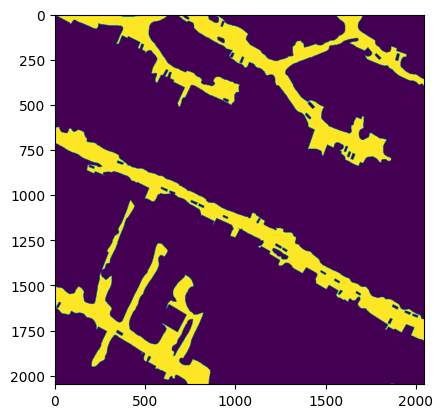

In [ ]:
mask = test_set[0][1]
plt.imshow(mask)

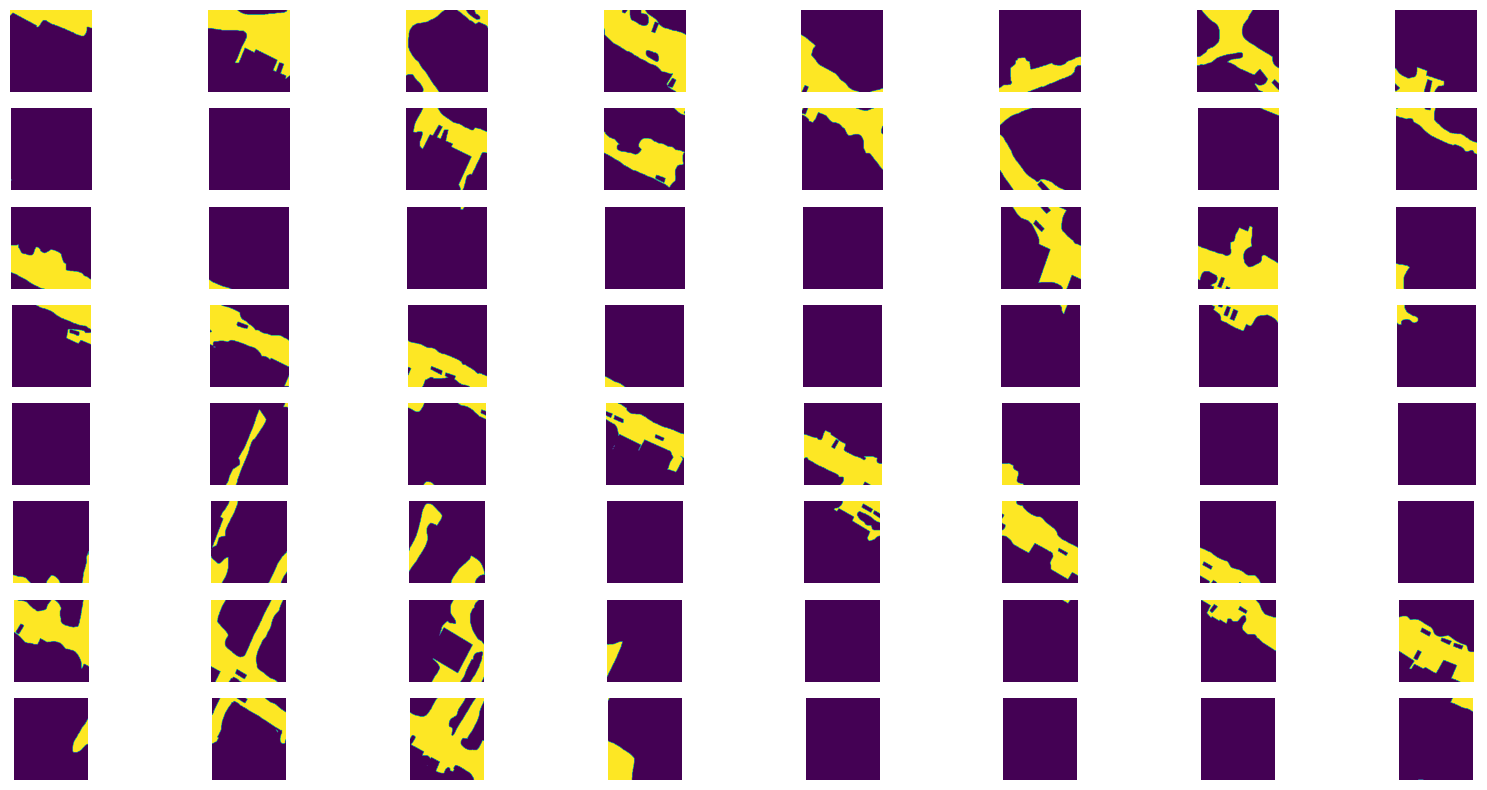

In [ ]:
fig, axs = plt.subplots(8,8, figsize=(20,10))
for i in range(8):
  for j in range(8):
    mask_ = test_set[0][1][i*252:(i+1)*256,j*256:(j+1)*256]

    axs[i][j].imshow(mask_)
    axs[i][j].set_axis_off()
    #vis_prediction(image, mask, pred_mask, score)

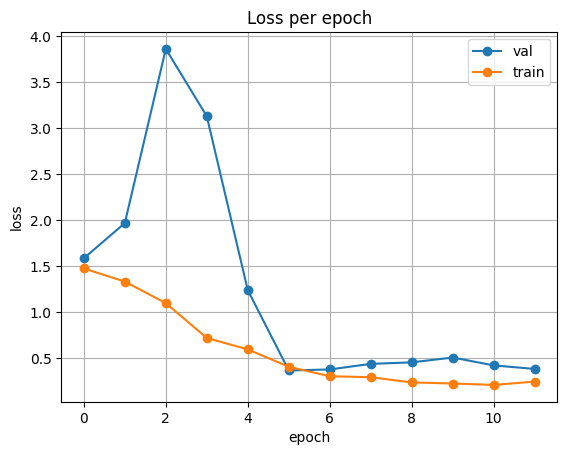

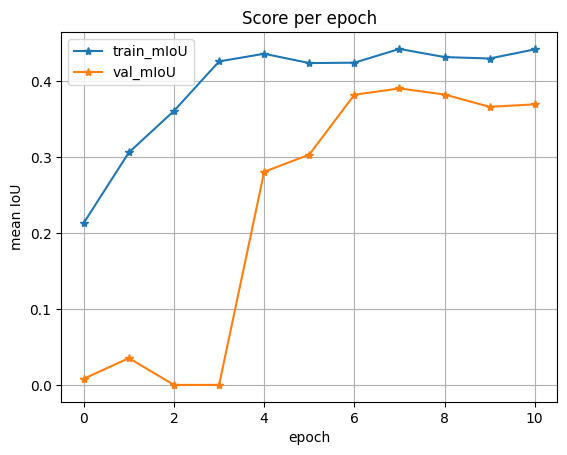

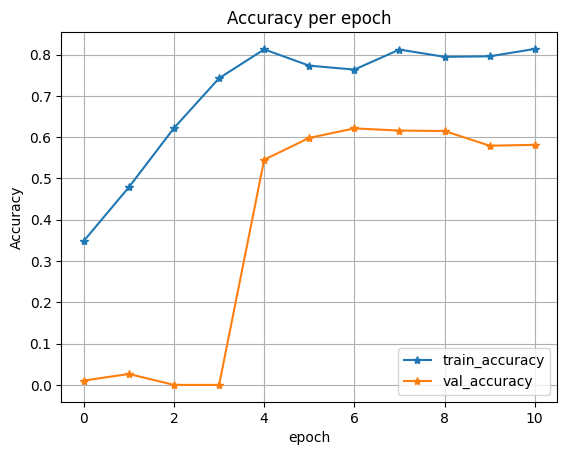

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [ ]:
print(mob_accs)
print(mob_mious)
print(scores)

[[0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756], [0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756], [0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756], [0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756, 0.8354928493499756]]
[[0.41774642467498785, 0.41774642467498785, 0.41774642467498785, 0.41774642467498785, 0.41774642467498785, 0.41774642467498785, 0.41774642467498785, 0.41774642467498785, 0.41774642467498785, 

### 6.1 Metrics for each class

pixel accuracy for each class

In [ ]:
pred1 = preds[0].numpy()
mask1 = masks[0].numpy()

pred2 = preds[1].numpy()
mask2 = masks[1].numpy()

pred3 = preds[2].numpy()
mask3 = masks[2].numpy()

pred4 = preds[3].numpy()
mask4 = masks[3].numpy()

In [ ]:
def acc_per_class(pred1, mask1):
  classes = [0,1,2,3,4]
  accuracy_list = []
  for class_ in classes:
    total = (mask1 == class_).sum()
    total_pred = (pred1 == class_).sum()
    total = total if total > 0 else 1
    right = ((pred1==class_).astype(int) + (mask1==class_).astype(int) == 2).sum()
    right = right if not ((total_pred == 0) and (total == 1)) else 1 
    accuracy_list.append(right/total)
  return accuracy_list

In [ ]:
acc_per_class(pred1, mask1)

[0.9988972374864491, 0.534651819843776, 0.0, 1.0, 1.0]

In [ ]:
acc_per_class(pred2, mask2)

[0.9352193844138834, 0.8383831000328935, 1.0, 1.0, 1.0]

In [ ]:
acc_per_class(pred3, mask3)

[1.0, 0.0, 1.0, 1.0, 1.0]

In [ ]:
acc_per_class(pred4, mask4)

[1.0, 1.0, 1.0, 1.0, 1.0]

### 6.2 Metrics for each class

pixel accuracy for each class

In [ ]:
pred1 = preds[0].numpy()
mask1 = masks[0].numpy()

pred2 = preds[1].numpy()
mask2 = masks[1].numpy()

pred3 = preds[2].numpy()
mask3 = masks[2].numpy()

pred4 = preds[3].numpy()
mask4 = masks[3].numpy()

In [ ]:
def acc_per_class(pred1, mask1):
  classes = [0,1,2,3,4]
  accuracy_list = []
  for class_ in classes:
    total = (mask1 == class_).sum()
    total_pred = (pred1 == class_).sum()
    print(total_pred, total)
    total = total if total > 0 else 1
    right = ((pred1==class_).astype(int) + (mask1==class_).astype(int) == 2).sum()
    right = right if not ((total_pred == 0) and (total == 1)) else 1 
    accuracy_list.append(right/total)
  return accuracy_list

In [ ]:
acc_per_class(pred1, mask1)

65536 53502
0 12034
0 0
0 0
0 0


[1.0, 0.0, 1.0, 1.0, 1.0]

In [ ]:
acc_per_class(pred2, mask2)

65536 38175
0 27361
0 0
0 0
0 0


[1.0, 0.0, 1.0, 1.0, 1.0]

In [ ]:
acc_per_class(pred3, mask3)

65536 65532
0 4
0 0
0 0
0 0


[1.0, 0.0, 1.0, 1.0, 1.0]

In [ ]:
acc_per_class(pred4, mask4)

65536 65536
0 0
0 0
0 0
0 0


[1.0, 1.0, 1.0, 1.0, 1.0]

### 7. Final analysis

The pre-trained model on Imagenet had the overall best results. It has higer accuracy, lower loss and higher mIoU for both train, validation and test data. The difference between the segmentated images is also large. The pre trained model segmentation looks much more correct than the trained from scratch model. Looking into the accuracy for each class is once again clear that the pre-trained was better. The trained from scratch predicted every pixel to be from the majority class, which is not good.